In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import torch

import numpy as np
import torchCompactRadius as tcr
from torchCompactRadius import neighborSearch, volumeToSupport
from torchCompactRadius.util import countUniqueEntries
from torchCompactRadius.radiusNaive import radiusNaive, radiusNaiveFixed
from torchCompactRadius.cppWrapper import neighborSearchSmall
import platform
import pandas as pd
import time
from tqdm.autonotebook import tqdm
import copy
import seaborn as sns

In [7]:
def generateNeighborTestData(nx, targetNumNeighbors, dim, maxDomain_0, periodic, device):


    minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
    maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
    maxDomain[0] = maxDomain_0
    periodicity = [periodic] * dim

    extent = maxDomain - minDomain
    shortExtent = torch.min(extent, dim = 0)[0].item()
    dx = (shortExtent / nx)
    ny = int(1 // dx)
    h = volumeToSupport(dx**dim, targetNumNeighbors, dim)
    dy = dx

    # print(f"dx = {dx}, dy = {dy}, h = {h}")
    # print(f"nx = {nx}, ny = {ny}")
    # print(f"minDomain = {minDomain}, maxDomain = {maxDomain}")
    # print(f"periodicity = {periodicity}")
    # print(f"dim = {dim}")
    # print(f"device = {device}")
    # print(f"maxDomain_0 = {maxDomain_0}")
    # print(f"targetNumNeighbors = {targetNumNeighbors}")
    

    positions = []
    for d in range(dim):
        positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
    grid = torch.meshgrid(*positions, indexing = 'xy')
    positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    supports = torch.ones(positions.shape[0], device = device) * h
    ypositions = []
    for d in range(dim):
        ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
    grid = torch.meshgrid(*ypositions, indexing = 'xy')
    y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    ySupport = torch.ones(y.shape[0], device = device) * supports[0]
    return (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, positions.shape[0]


In [8]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2
periodic = False

(y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, periodic, device)
for i in range(256):
    (i_cpu, j_cpu), neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
                

In [9]:
from torch_cluster import radius

In [11]:
(y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)

In [13]:
torch.tensor(periodicity).to(device)

tensor([False, False], device='cuda:0')

In [25]:
def callRadiusNaive(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        r = radiusNaive(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, mode)
    return r

    # i, j = neighborSearchSmall(y, ySupport, positions, supports, minDomain, maxDomain, periodicTensor, 'symmetric')

def callRadiusSmall(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        r = neighborSearchSmall(y, ySupport, positions, supports, minDomain, maxDomain, torch.tensor(periodicity).to(device), mode)
    return r

def callRadiusCompact(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        r = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, mode, 'cpp')
    return r

def callRadius(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        (i,j) = radius(y, positions, supports[0], max_num_neighbors = 384)
    return (j,i)

In [27]:
def callNeighborSearch(algorithm, y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    if algorithm == 'naive':
        return callRadiusNaive(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)
    elif algorithm == 'small':
        return callRadiusSmall(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)
    elif algorithm == 'compact':
        return callRadiusCompact(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)
    elif algorithm == 'torch':
        return callRadius(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)


In [32]:
dataset = pd.DataFrame()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
targetNumNeighbors = 50


In [35]:
ptcls = np.logspace(8, 15, 64, base = 2).astype(int)
dims = [1,2,3]
periodics = ['naive', 'small', 'compact', 'torch']
iters = 8

t_periodic = tqdm(periodics)
t_nx = tqdm(ptcls)
t_dim = tqdm(dims)
t_iter = tqdm(range(iters))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [36]:
t_periodic.reset()
for periodic in periodics:
    t_periodic.set_description("periodic = %s" % periodic)
    t_nx.reset()
    for ptcl in ptcls:
        t_nx.set_description("ptcls = %d" % ptcl)
        t_dim.reset()
        for dim in dims:
            nx = int(ptcl ** (1 / dim))
            t_dim.set_description("dim = %d, nx = %d" % (dim, nx))
            (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)
            # print(y.shape, positions.shape, ySupport.shape, supports.shape, minDomain, maxDomain, periodicity, hashMapLength)

            callNeighborSearch(periodic, y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, 'scatter', device, 1)

            # (i_cpu, j_cpu), neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
            # del i_cpu, j_cpu, neighborDict
            t_iter.reset()
            for i in range(iters):
                t_iter.set_description("i = %d" % i)
                start_time = time.time()
                # for i in range(8):
                callNeighborSearch(periodic, y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, 'scatter', device, 1)
                # (i_cpu, j_cpu), neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
                end_time = time.time()
                torch.cuda.empty_cache()        

                df = pd.DataFrame({
                    'ptcls': nx**dim, 'nx': nx, 'dim': dim, 'targetNumNeighbors': periodic, 
                    'time': end_time - start_time, 'device': device.type, 'algorithm': periodic
                    # 'ni_cpu.min()': ni_cpu.min().item(), 'ni_cpu.max()': ni_cpu.max().item(), 'nj_cpu.min()': nj_cpu.min().item(), 'nj_cpu.max()': nj_cpu.max().item()
                    }, index = [0])
                if i > 0:
                    dataset = pd.concat([dataset, df], ignore_index = True)
                t_iter.update()
            t_dim.update()
        t_nx.update()
    t_periodic.update()

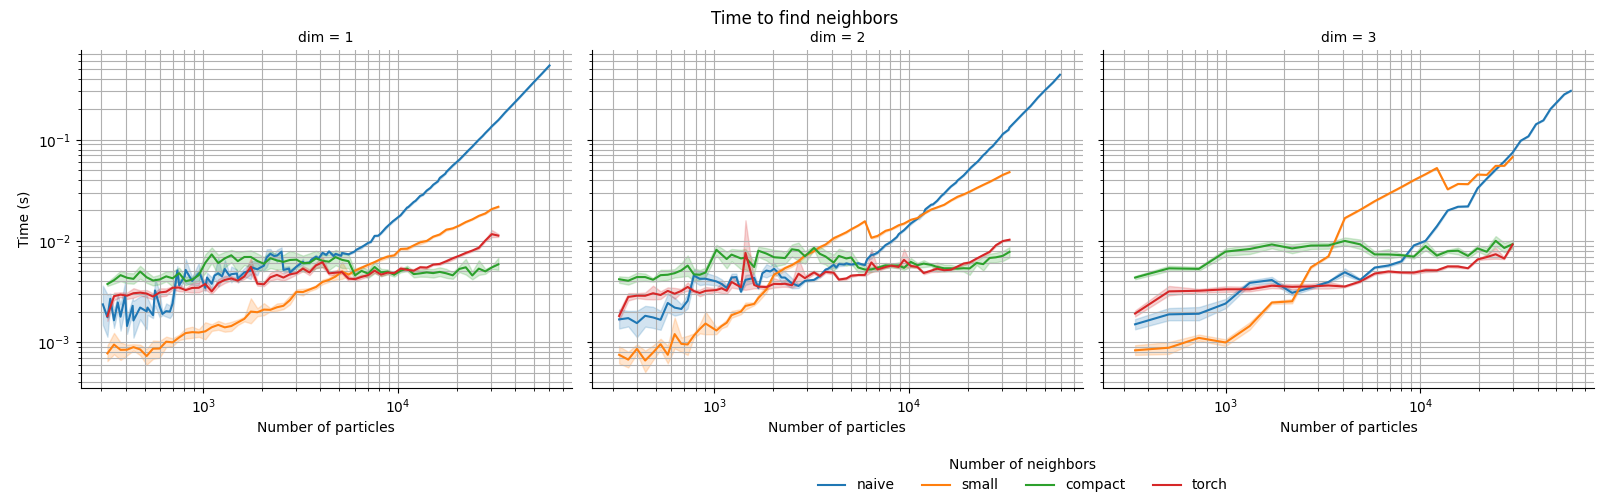

In [38]:
data = copy.deepcopy(dataset)
data = data[data['ptcls'] > 300]
data['dim'] = data['dim'].astype('category')
data['targetNumNeighbors'] = data['targetNumNeighbors'].astype('category')

g = sns.relplot(data = data, x = 'ptcls', y = 'time', hue = 'algorithm', kind = 'line', col = 'dim')

for ax in g.axes.flat:
    ax.set_xlabel('Number of particles')
    ax.set_ylabel('Time (s)')
    ax.grid(True, which='both')

g.figure.suptitle('Time to find neighbors')

sns.move_legend(g, 'center left', bbox_to_anchor=[.5, 0.05], ncols=4, title='Number of neighbors')
g.axes[0,0].set_xscale('log')
g.axes[0,0].set_yscale('log')
g.figure.tight_layout()
plt.subplots_adjust(left=0.05, right=0.99, top=0.9, bottom=0.225)

In [7]:
import torch.autograd.profiler as profiler

with profiler.profile(record_shapes=False, use_cuda=torch.cuda.is_available()) as prof:
    for i in range(32):
        with profiler.record_function("neighborSearch"):
            (i_cpu, j_cpu), ni_cpu, nj_cpu, neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')

print(prof.key_averages().table(sort_by="cpu_time_total"))

# Export the trace
# prof.export_chrome_trace("trace.json")


INFO:2024-02-13 00:11:28 864:864 init.cpp:149] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti
STAGE:2024-02-13 00:11:28 864:864 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-02-13 00:11:33 864:864 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-02-13 00:11:33 864:864 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         neighborSearch         0.20%       8.965ms       100.00%        4.456s     139.248ms       1.045ms         0.02%        4.517s     141.171ms            32  
                neighborSearch - sortReferenceParticles         1.66%      73.884ms        59.37%        2.645s      41.336ms      37.607ms         0.83%     705.903ms      11.030ms            64  
         